# Test Natural Gradient

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from agents.pgp.pgp_softmax import SoftMaxPGP
from environments.gridworlds.gridworlds_classic import SimpleGrid, MiniWorld, FourRoom
from plots.gridworlds.gridworld_visualizer import GridWorldVisualizer
from utils.policy_functions import *

### Parameters

In [3]:
# World Parameters
maze_type = FourRoom
n_maze = 5

# Model Parameters
gamma = 0.99

# Training Parameters
p0_func = p0_onehot
alpha = 0.01
n_steps = 5000

# Plots Parameters
n_plots = 25
fim_columns_shown = 100

### Maze

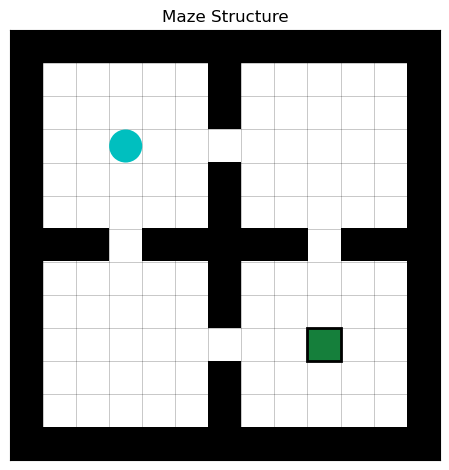

In [4]:
world = maze_type(n_maze)
viz = GridWorldVisualizer(world)

viz.plot_maze(plot_axis=False)
plt.title("Maze Structure")
plt.tight_layout()


In [5]:
def FIM_components(agent, i1=True, i2=True, i3=True, i4=True):
    '''
        Returns the Fisher Information matrix FIM_i,j,k,l with i,k ∈ S, j,l ∈ A
    '''
    π = agent.policy_vec()
    CC_aa = agent.CorrCount_AA
    CC_as = agent.CorrCount_AS
    CC_ss = agent.CorrCount_SS
    
    I_aa = CC_aa
    I_as = np.einsum("ijk, kl -> ijkl", CC_as, π, optimize=True)
    I_sa = np.einsum("kli, ij -> ijkl", CC_as, π, optimize=True)
    I_ss = np.einsum("ik, ij, kl -> ijkl", CC_ss, π, π, optimize=True)
    FIM = I_aa*i1 - I_sa*i2 - I_as*i3 + I_ss*i4

    nsa = agent.n_state * agent.n_action
    FIM = FIM.reshape([nsa, nsa])
    FIM = FIM[agent.A.reshape(nsa), :]
    FIM = FIM[:, agent.A.reshape(nsa)]

    return FIM

/home/fran-tr/Workspace/gpp_core/utils/policy_functions.py:43: RuntimeWarning: divide by zero encountered in log
  return np.log(agent.A / np.sum(agent.A, axis=1, keepdims=True))


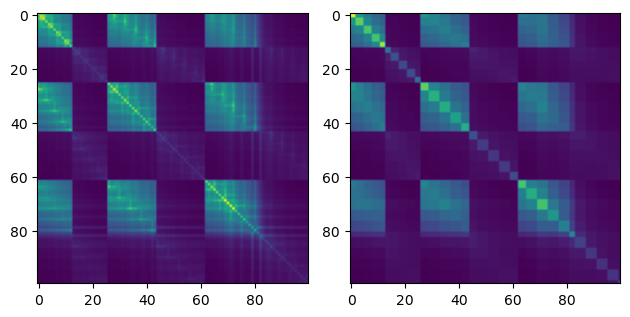

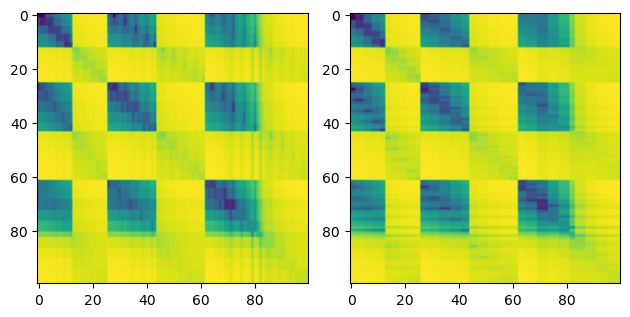

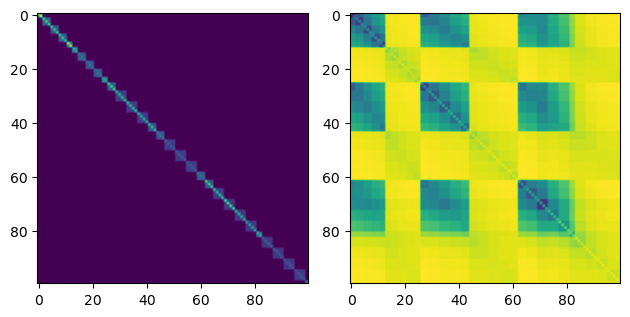

In [6]:
a = SoftMaxPGP(world, gamma=gamma, p0_func=p0_func) 

plt.subplot(1,2,1)
plt.imshow(FIM_components(a, True, False, False, False)[:fim_columns_shown,:fim_columns_shown])
plt.subplot(1,2,2)
plt.imshow(FIM_components(a, False, False, False, True)[:fim_columns_shown,:fim_columns_shown])
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.imshow(FIM_components(a, False, True, False, False)[:fim_columns_shown,:fim_columns_shown])
plt.subplot(1,2,2)
plt.imshow(FIM_components(a, False, False, True, False)[:fim_columns_shown,:fim_columns_shown])
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.imshow(FIM_components(a, True, True, True, True)[:fim_columns_shown,:fim_columns_shown])
plt.subplot(1,2,2)
plt.imshow(FIM_components(a, True, True, True, False)[:fim_columns_shown,:fim_columns_shown])
plt.tight_layout()
plt.show()



### Natural Gradient

100%|██████████| 200/200 [00:01<00:00, 152.69it/s]


iteration #200:


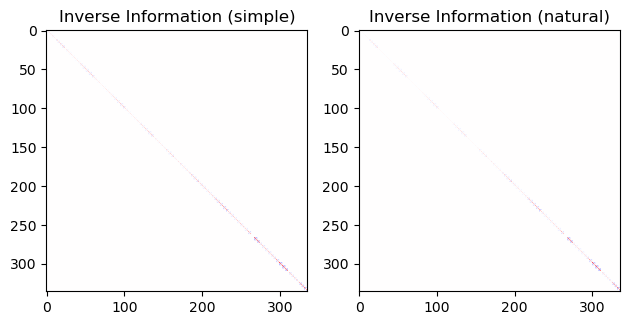

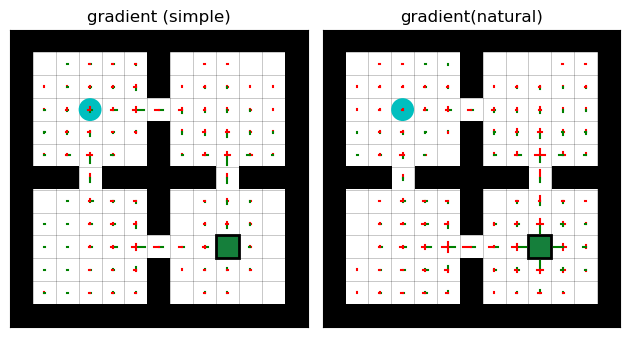

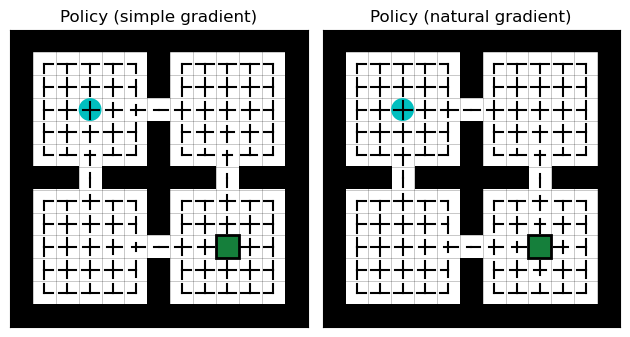

100%|██████████| 200/200 [00:01<00:00, 154.80it/s]


iteration #400:


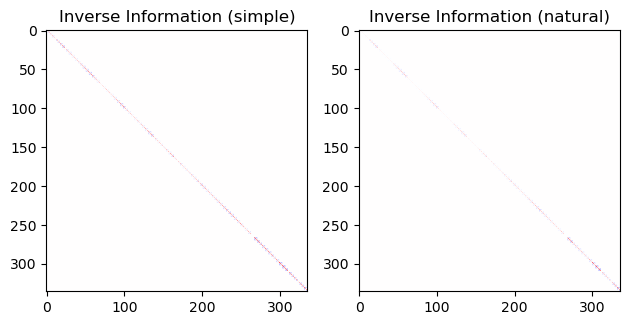

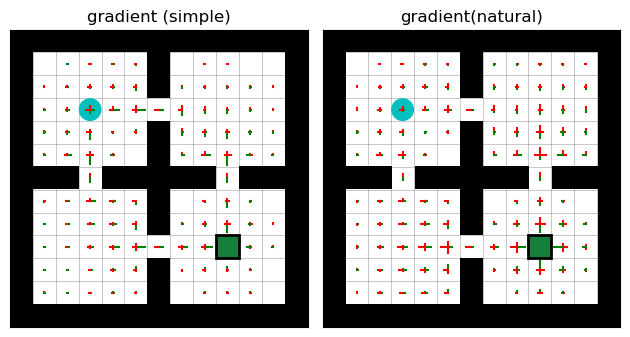

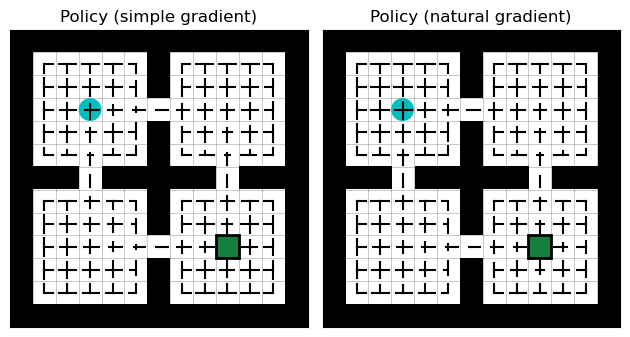

100%|██████████| 200/200 [00:01<00:00, 147.11it/s]


iteration #600:


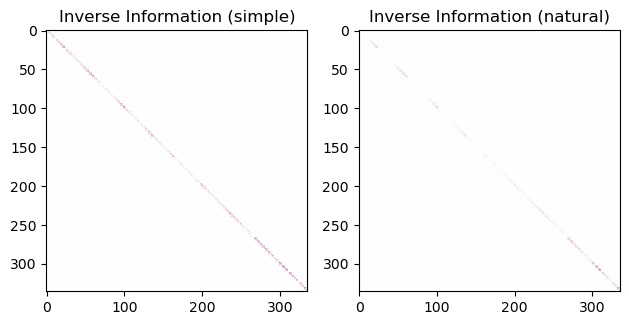

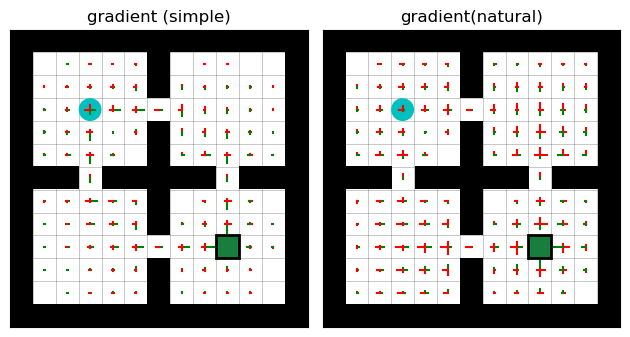

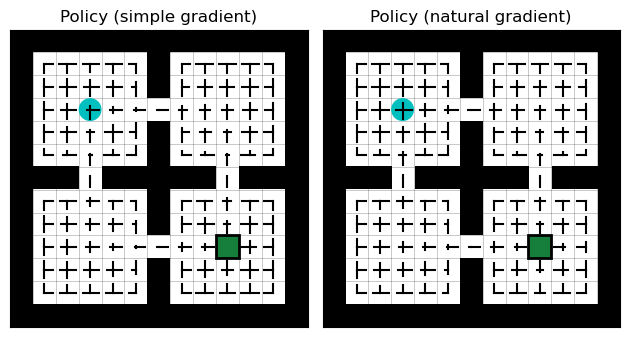

100%|██████████| 200/200 [00:01<00:00, 164.07it/s]


iteration #800:


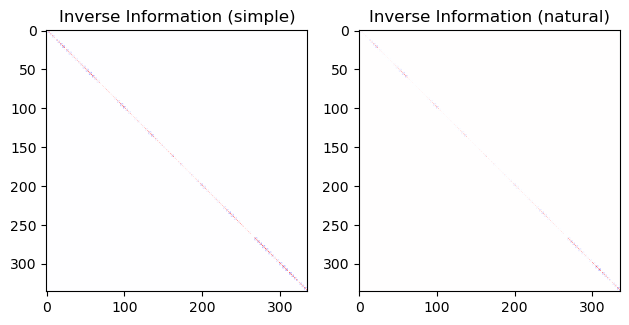

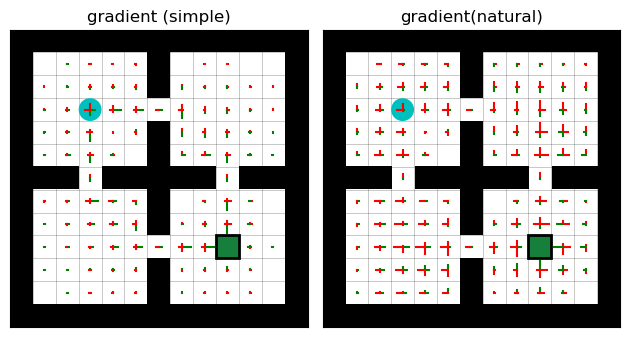

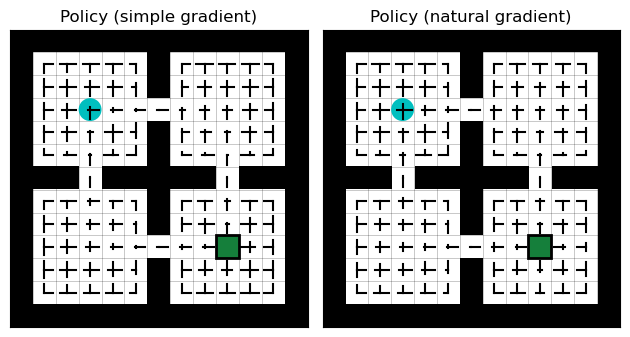

100%|██████████| 200/200 [00:01<00:00, 160.99it/s]


iteration #1000:


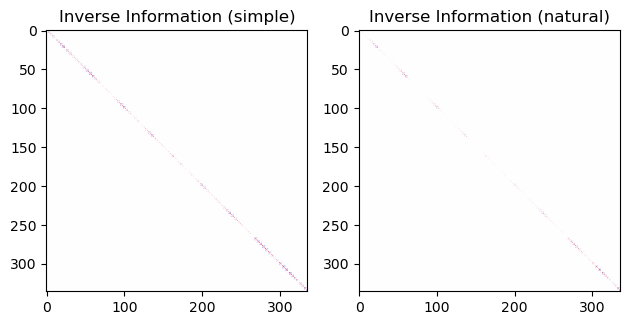

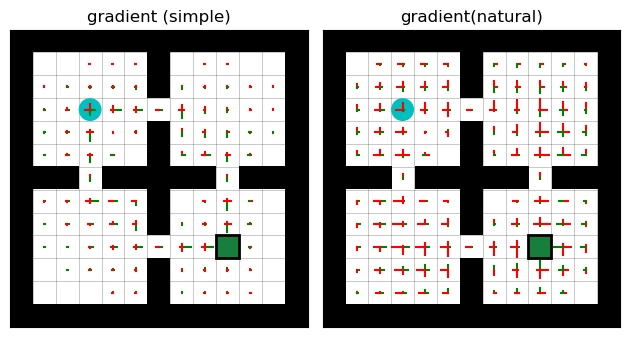

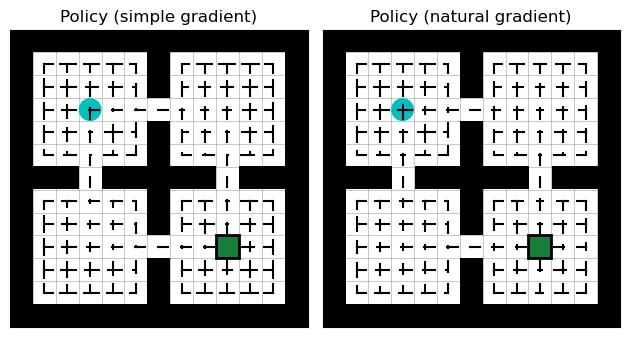

 94%|█████████▎| 187/200 [00:01<00:00, 148.63it/s]


KeyboardInterrupt: 

In [7]:
ag = SoftMaxPGP(world, gamma=gamma, p0_func=p0_func) 
an = SoftMaxPGP(world, gamma=gamma, p0_func=p0_func)

vg = GridWorldVisualizer(world, ag)
vn = GridWorldVisualizer(world, an)

n_plot_steps = round(n_steps/n_plots)
for i in range(1, 1+n_plots):
    
    # Train
    ag.learn(n_steps=n_plot_steps, alpha=alpha, gradient_kwargs={"natural":False})
    an.learn(n_steps=n_plot_steps, alpha=alpha, gradient_kwargs={"natural":True})

    print("iteration #{}:".format(i*n_plot_steps))


    # Plot Inverse Fisher Information
    Gg = np.linalg.inv(ag.FIM())
    Gn = np.linalg.inv(an.FIM())
    
    Gg_plot = Gg#[:fim_columns_shown, :fim_columns_shown]
    Gn_plot = Gn#[:fim_columns_shown, :fim_columns_shown]
    
    plt.subplot(1,2,1)
    plt.imshow(Gg_plot, cmap="bwr", vmin=-np.max(np.abs(Gg)), vmax=np.max(np.abs(Gg)))
    plt.title("Inverse Information (simple)")
    
    plt.subplot(1,2,2)
    plt.imshow(Gn_plot, cmap="bwr", vmin=-np.max(np.abs(Gn)), vmax=np.max(np.abs(Gn)))
    plt.title("Inverse Information (natural)")

    plt.tight_layout()
    plt.show()


    # Plot Gradients
    plt.subplot(1,2,1)
    vg.plot_policy(vec=ag.gradient(natural=False) / np.max(ag.gradient(natural=False)), normalize=False, plot_axis=False)
    plt.title("gradient (simple)")

    plt.subplot(1,2,2)
    vg.plot_policy(vec=ag.gradient(natural=True) / np.max(ag.gradient(natural=True)), normalize=False, plot_axis=False)
    plt.title("gradient(natural)")
    
    plt.tight_layout()
    plt.show()

        
    # Plot Policy
    plt.subplot(1,2,1)
    vg.plot_policy(plot_axis=False)
    plt.title("Policy (simple gradient)")

    plt.subplot(1,2,2)
    vn.plot_policy(plot_axis=False)
    plt.title("Policy (natural gradient)")
    
    plt.tight_layout()
    plt.show()